# Python project to predict rating for a given book

### Target: The aim of this project is to train a machine learning model to predict book rating and deploy it in a streamlit web app. 

### All the steps from importing, data analysis, feature engineering, machine learning model and streamlit app will be explained within the notebook.

In [89]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline
from warnings import filterwarnings

import pickle
    
from scipy.stats import pearsonr

from sklearn import preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### Step 1 - Reading dataset and core data analysis

In [90]:
data = pd.read_csv('books.csv', error_bad_lines = False)

# error_bad_lines argument allows to handle some lines for example these where commas are contained in authors names. This causes a column shift for the rows where this is the case.
# For example: line with bookID 12224.

data.head()

<ipython-input-90-f7f61d46a7d3>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('books.csv', error_bad_lines = False)
b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [92]:
# Checking null values or duplicated values in dataset

    # null values

data.info()

    # Little cleansing
    
data.columns = data.columns.str.replace(' ', '')

# We don't have any missing values in our fields

    # duplicated values
print('------------------------')
print(f"We have {data.duplicated().sum()} number(s) of duplicated row(s) in the dataset.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB
------------------------
We have 0 number(s) of duplicated row(s) in the dataset.


In [85]:
# After reading data description and metadata, we note that fields bookID, isbn and isbn13 contain same information. 
#The aim of these fields is to give a primary key for each row. So we decide to delete them in order to gain speed and to focus on columns that can be used to enrich the model or that have strong dependencies with the ratings column.

data = data.drop(['bookID','isbn','isbn13'], axis=1)

In [86]:
# Let's see one more time the number of rows/fields in our dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11123 non-null  object 
 1   authors             11123 non-null  object 
 2   average_rating      11123 non-null  float64
 3   language_code       11123 non-null  object 
 4   num_pages           11123 non-null  int64  
 5   ratings_count       11123 non-null  int64  
 6   text_reviews_count  11123 non-null  int64  
 7   publication_date    11123 non-null  object 
 8   publisher           11123 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 782.2+ KB


#### Data visualisation

##### Let's analyze numerical variables

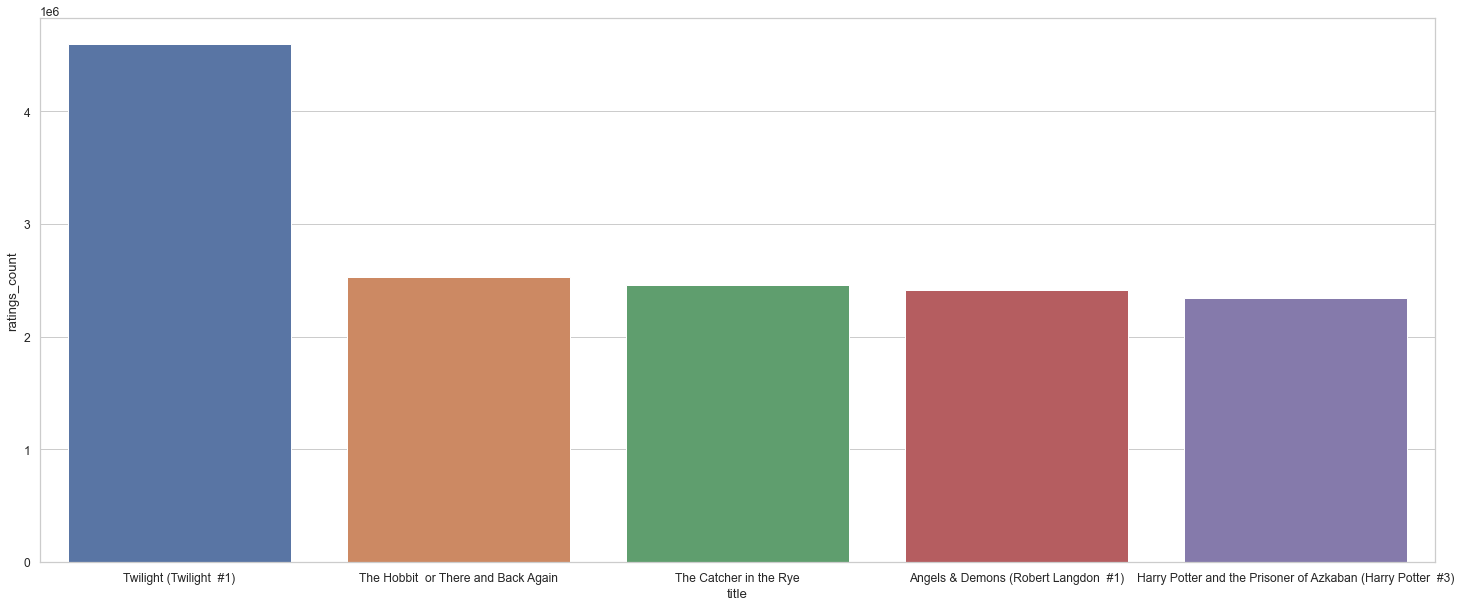

In [87]:
# We explore the total ratings_count by title to take knowledge about the most reviewed books
best_ratings_count_books = data.nlargest(5, 'ratings_count')

plt.figure(figsize=(25,10))
sns.barplot(data=best_ratings_count_books, x='title',y='ratings_count');

In [81]:
best_ratings_count_books

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
10336,Twilight (Twilight #1),Stephenie Meyer,3.59,eng,501,4597666,94265,9/6/2006,Little Brown and Company
1697,The Hobbit or There and Back Again,J.R.R. Tolkien,4.27,eng,366,2530894,32871,8/15/2002,Houghton Mifflin
1462,The Catcher in the Rye,J.D. Salinger,3.80,eng,277,2457092,43499,1/30/2001,Back Bay Books
307,Angels & Demons (Robert Langdon #1),Dan Brown,3.89,eng,736,2418736,21303,4/1/2006,Pocket Books
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,Scholastic Inc.


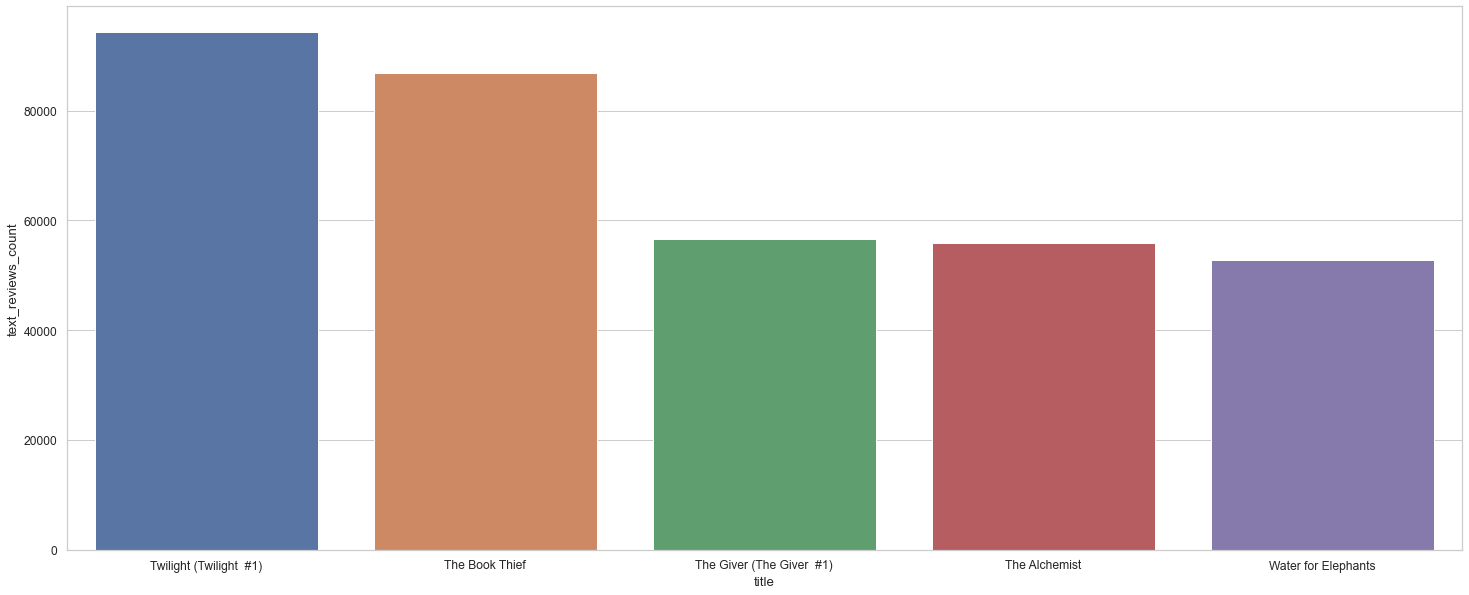

In [88]:
# We do the same analysis to know the books with highest text_reviews_count

best_text_reviews_count = data.nlargest(5, 'text_reviews_count')

plt.figure(figsize=(25,10))
sns.barplot(data=best_text_reviews_count, x='title',y='text_reviews_count');

# => Conclusion: Books with many text_reviews have also lots of rating count

In [105]:
# Let's explore the correlation between these two variables and average rating

#plt.figure(figsize=(15,10))
#sns.scatterplot(x=data['average_rating'], y=data['ratings_count']);

#plt.figure(figsize=(15,10))
#sns.scatterplot(x=data['average_rating'], y=data['text_reviews_count']);


# assuming your dataframe is called 'data'
fig1 = px.scatter(data, x='average_rating', y='ratings_count', width=900, height=600)
fig1.show()

fig2 = px.scatter(data, x='average_rating', y='text_reviews_count', width=900, height=600)
fig2.show()

In [ ]:
# => Conclusion of above analysis: The main part of books are located under 20000 text_reviews and rating_counts apart from some others as the five we saw aove

C:\Users\egakosso\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


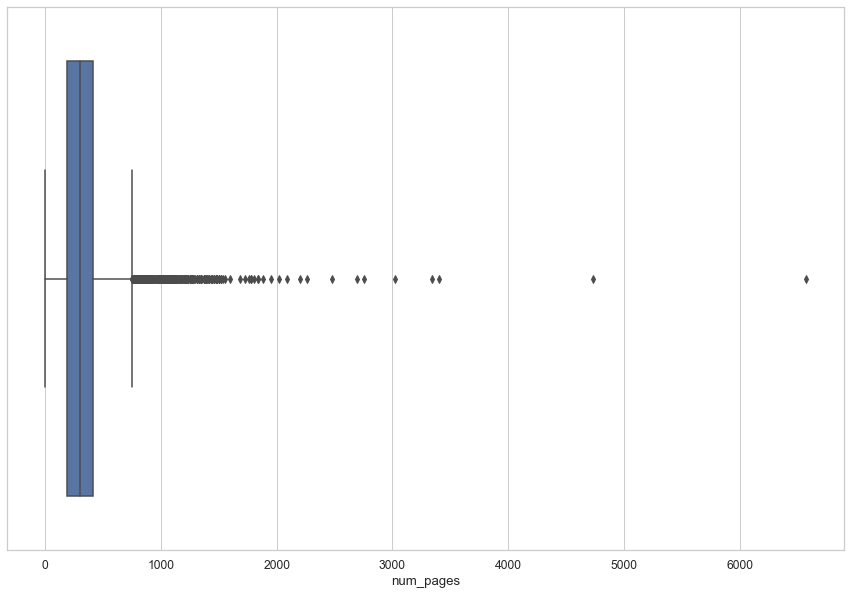

In [52]:
# Let's analyse the relationships between number of pages and average_rating and the distribution of number of pages in our books dataset

plt.figure(figsize=(15,10))
sns.boxplot(data['num_pages']);

In [94]:
fig = px.scatter(data, x='average_rating', y='num_pages')
fig.show()

In [ ]:
# => After analyzing the distribution of num_pages and the relationship between it and average_rating, we can say that the books with num_pages above 1000 are outliers and can can negatively affect the quality of the model seeing the fact that most of books contain under 1000 pages
# => Same conclusion for rating_counts above 1e6 and text_reviews_count above 20000

C:\Users\egakosso\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


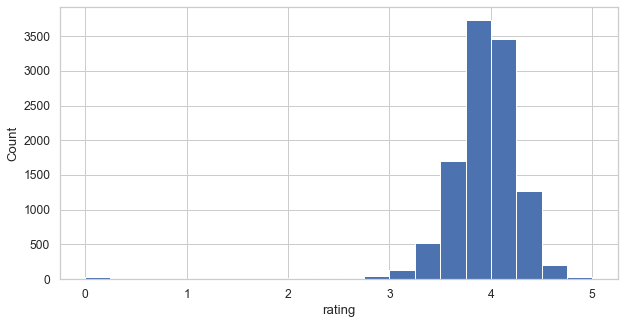

In [54]:
# Let's analyse the distribution of target variable

import seaborn as sns

plt.figure(figsize=(10,5))
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    data['average_rating'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='rating', ylabel='Count');


# The conclusion of analysis: People rate books on a scale of mainly 3 to 4. Very few if any books are rated at 0, 1 and 2 and a very small minority also rate at 5.

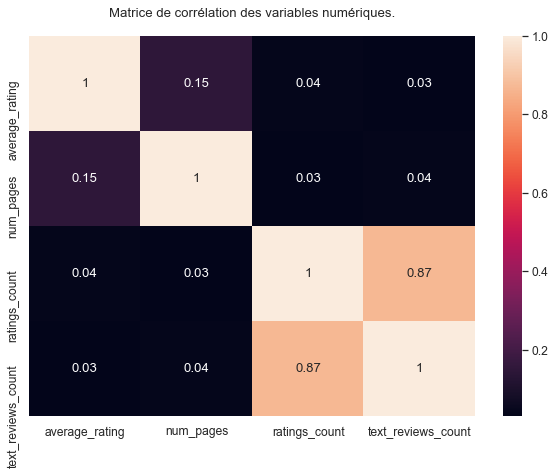

In [55]:
# Correlation analysis

correlation_matrix = data.corr().round(2)
plt.figure(figsize=(10,7))
plt.title("Matrice de corrélation des variables numériques.\n")
sns.heatmap(data=correlation_matrix, annot=True);

# => L'ensemble des variables explicatives sont faiblement correlées à la variable cible. 

In [56]:
# Pearson Correlation Test for dependance analysis
# Our null hypothesis is that two variables are independants.

print('------ Pearson Correlation Test between average_rating and num_pages -----------------')
print(pd.DataFrame(pearsonr(data['num_pages'],data['average_rating']),
            index=['pearson_coeff','p-value'],
            columns=['result']))
print('\n')

print('------ Pearson Correlation Test between text_reviews_count and average_rating -----------------')
print(pd.DataFrame(pearsonr(data['text_reviews_count'],data['average_rating']),
            index=['pearson_coeff','p-value'],
            columns=['result']))
print('\n')

print('------ Pearson Correlation Test between ratings_count and average_rating -----------------')
print(pd.DataFrame(pearsonr(data['ratings_count'],data['average_rating']),
            index=['pearson_coeff','p-value'],
            columns=['result']))

# => There is less than a 5% chance that the observed correlation between the explanatory variables and book evaluation is due to chance. In other words, this suggests that there is a strong correlation between the two variables studied. The correlation is statistically significant.

------ Pearson Correlation Test between average_rating and num_pages -----------------
                     result
pearson_coeff  1.504766e-01
p-value        2.455680e-57


------ Pearson Correlation Test between text_reviews_count and average_rating -----------------
                 result
pearson_coeff  0.033663
p-value        0.000384


------ Pearson Correlation Test between ratings_count and average_rating -----------------
                 result
pearson_coeff  0.038224
p-value        0.000055


##### Let's analyze categorical variables we keep in dataset (publisher, language_code and authors)

In [57]:
print('List of some of the best publishers')
print(data.groupby(['publisher'])['average_rating'].mean().sort_values(ascending=False).head(20))

# How many distinct publishers we have ?

print('-------------------------------------')
print(f"There are {data['publisher'].nunique()} unique publishers in our dataset.")

# According to the large number of publishers, it's not suitable to build a chart to see the distribution of each of them.
# But for the analysis of output of machine learning model, we keep in mind the name of some of the best of them.

List of some of the best publishers
publisher
Boosey & Hawkes Inc                5.00
Schirmer Mosel                     5.00
Chartwell Books                    5.00
Vantage Press                      5.00
Y Lolfa                            5.00
Square One Publishers              5.00
Courage Books                      5.00
Academica Press                    5.00
University Press of New England    5.00
Raintree                           5.00
T&T Clark Int'l                    5.00
Texas A&M University Press         5.00
Welcome Books                      4.88
Teacher's Pet Publications         4.86
Universe Publishing(NY)            4.83
F. Meiner                          4.78
Skinner House Books                4.75
Steidl                             4.73
Four Ninety-Eight Productions      4.72
Zondervan Publishing House         4.70
Name: average_rating, dtype: float64
-------------------------------------
There are 2290 unique publishers in our dataset.


There are 27 unique language code in our dataset.
----------------------------


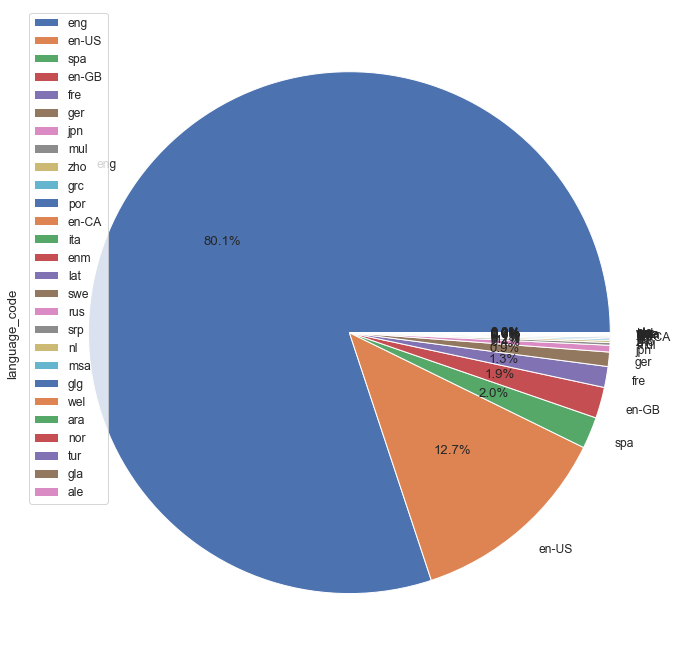

In [58]:
print(f"There are {data['language_code'].nunique()} unique language code in our dataset.")

# Let's do a chart to analyse and have an idea about the main languages represented

print('----------------------------')
#plt.figure(figsize=(30,15))
data['language_code'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(20, 12)).legend();

# => Conclusion: Most of books are written in english and few books in spanish or french. A really small sample of others vooks are written in other languages

<AxesSubplot:xlabel='authors', ylabel='ratings_count'>

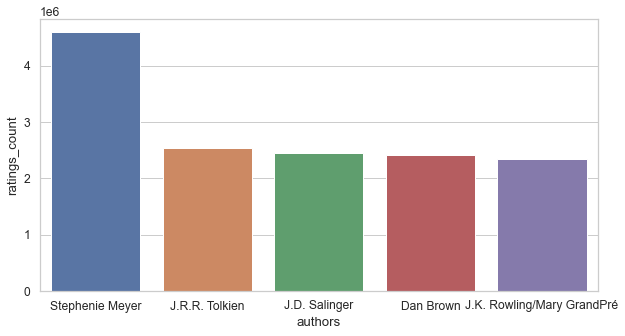

In [59]:
# In order to recommand a special author for a given book, let's analyze the authors with many ratings_count

plt.figure(figsize=(10, 5))
authors = data.nlargest(5, ['ratings_count'])

sns.barplot(data=authors, x='authors', y='ratings_count')

### Step 2 - Feature engineering and data preprocessing (based on data analysis)

#### Categorical variables

In [60]:
#data.head(10)

# Publication_date : The date of publication of a book may be important for understanding the context in which it was written and for appreciating its historical or cultural significance, but it does not necessarily determine whether the book is appreciated or not. So we decide to delete this field.
# Publisher: The publisher of a book is not a reliable indicator of whether a book is popular or not. Although some publishers have a reputation for publishing high quality books, there are many factors that influence the popularity of a book, such as the author, subject matter, writing style, promotion, etc. In addition, a book may be well received by the public even if it is published by a small, little-known publisher, whereas a book published by a large publisher may not be as successful. So let's delete this field too.
# title: We have more than 10.000 occurrences of different title in dataset. One-hot encoding is not suitable because the number of variables will be huge and labelencoding is not suitable because we do not have an inherent order.


data = data.drop(['publication_date','publisher','title'], axis=1)

In [61]:
# Mean-based encoding on categorical variables


te_authors = TargetEncoder()

data['authors'] = te_authors.fit_transform(data['authors'].values,data['average_rating'].values)

te_language = TargetEncoder()

data['language_code'] = te_language.fit_transform(data['language_code'].values,data['average_rating'].values)

data.head()

,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count
0,4.055585,4.57,3.934062,652,2095690,27591
1,4.055585,4.49,3.934062,870,2153167,29221
2,4.101598,4.42,3.934062,352,6333,244
3,4.055585,4.56,3.934062,435,2339585,36325
4,4.055585,4.78,3.934062,2690,41428,164


#### Numerical variables

In [62]:
# Remove outliers: As we saw during data analysis, there are few outliers in fields rating_counts, text_reviews_count and num_pages.

treshold_rating_counts = 800000
treshold_text_reviews_count = 20000
treshold_num_pages = 1200

data = data[data['ratings_count'] <= treshold_rating_counts]
data = data[data['text_reviews_count'] <= treshold_text_reviews_count]
data = data[data['num_pages'] <= treshold_num_pages]

In [63]:
# Normalisation of numerical variables to remove the effect of scaling values that are different between these columns

numerical_features = ['num_pages','ratings_count','text_reviews_count']

# create a RobustScaler object
scaler = RobustScaler()

# fit the scaler to the numerical features
scaler.fit(data[numerical_features])

# transform the numerical features using the scaler
scaled_features = scaler.transform(data[numerical_features])

# replace the original features in the dataframe with the scaled features
data[numerical_features] = scaled_features

In [64]:
data.head(10)

,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count
2,4.101598,4.42,3.934062,0.259091,1.169303,0.887892
5,3.908824,3.74,3.914659,-0.650000,-0.149204,-0.201794
7,4.038681,4.38,3.934062,2.363636,0.604437,0.932735
8,4.038681,4.38,3.934062,2.363636,51.960219,18.089686
9,4.038681,4.22,3.934062,-0.363636,0.876325,1.856502
10,3.971277,4.22,3.934062,-1.313636,0.111198,0.928251
11,4.038681,4.38,3.934062,2.363636,0.447612,0.668161
12,3.934186,4.21,3.934062,1.131818,51.751397,41.928251
13,3.934186,3.44,3.934062,-1.090909,1.364970,2.031390
14,3.934186,3.87,3.934062,-0.177273,0.282850,0.381166


### Step 3 -  Machine learning Model

In [65]:
X = data[['num_pages','ratings_count','text_reviews_count','authors','language_code']]
y = data['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

#### Linear Regression Model

In [66]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [67]:
predictions = lr.predict(X_test)
predictions

array([4.14243819, 3.65463631, 3.99890728, ..., 3.85072757, 3.88468662,
       3.58602996])

In [68]:
# Let's analyse the results of trained model

pred = pd.DataFrame({'Actual': y_test.tolist(), 
                     'Predicted': predictions.tolist()}).head(15)
pred.head(15)

,Actual,Predicted
0,4.36,4.142438
1,3.60,3.654636
2,4.03,3.998907
3,4.28,4.243348
4,4.16,4.117879
5,3.63,3.690930
6,3.91,3.943390
7,3.90,3.934119
8,4.24,4.204282
9,3.76,4.013480


### Step 4 - Analysis of results model

Text(0.5, 1.0, 'Actual Vs Predicted value')

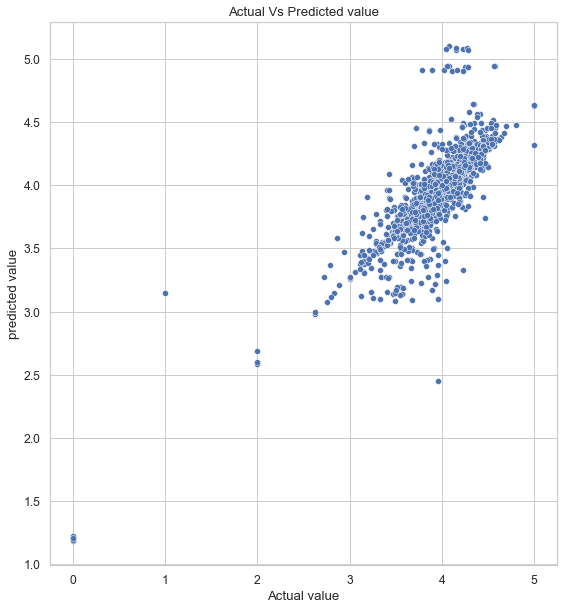

In [69]:
# Check for Linearity

f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test,y=predictions,ax=ax)
plt.xlabel('Actual value')
plt.ylabel('predicted value')
ax.set_title('Actual Vs Predicted value')

# => Apart from about 5 outliers. The predictions are enough goods and the model generalises well the data on the test set.

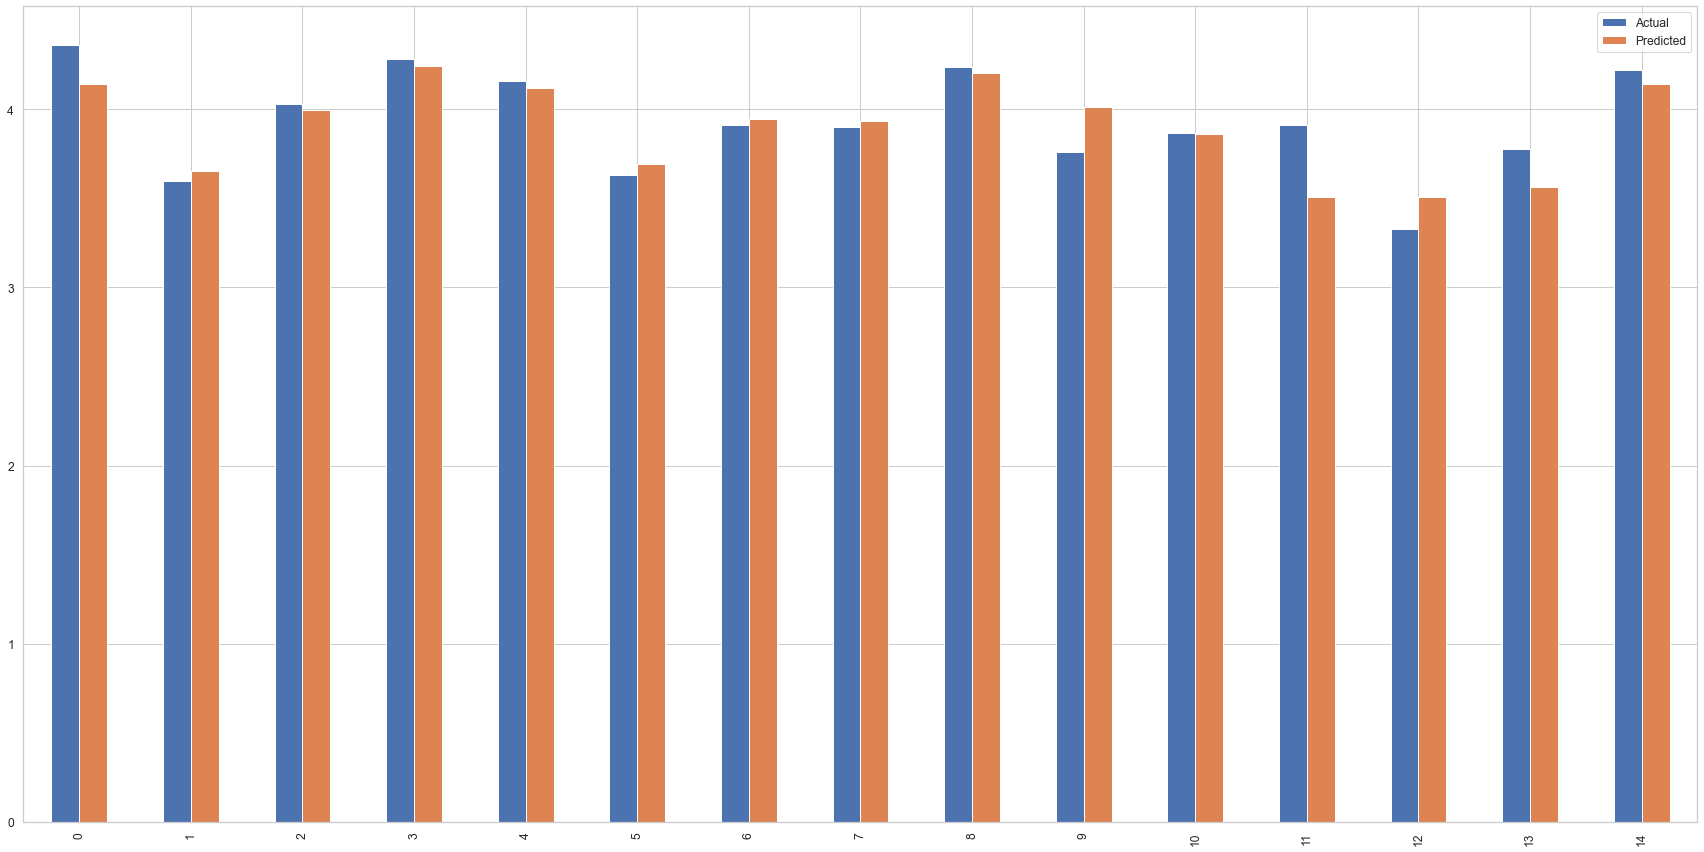

In [70]:
# visualise the above comparison result
pred.plot(kind='bar', figsize=(30,15));

In [71]:
# Evaluate model perfomance
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2:', lr.score(X,y))

# The R2 is about 0.87 So 87.5% of the variability in the dependent variable can be explained by the independent variables included in the model.
# The MAE is about 0.06 so on average, the model's predictions are off by about 0.06 units of the target variable.
# In conclusion, the model can be considered as a good model.

MAE: 0.11878237298445021
MSE: 0.03794063195935887
RMSE: 0.19478355156264832
R2: 0.7181789617563411


#### Test with Random Forest Model

In [72]:
rf_reg = RandomForestRegressor(n_estimators=250, random_state=44)
rf_reg.fit(X_train, y_train)

# Predicting on Test Data
y_pred = rf_reg.predict(X_test)

# Evaluating Model Performance
from sklearn.metrics import mean_absolute_error, r2_score
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

MAE: 0.08221732188394502
MSE: 0.022940656713749254
RMSE: 0.1514617334964487
R2: 0.8424894102786511


Text(0.5, 1.0, 'Actual Vs Predicted value')

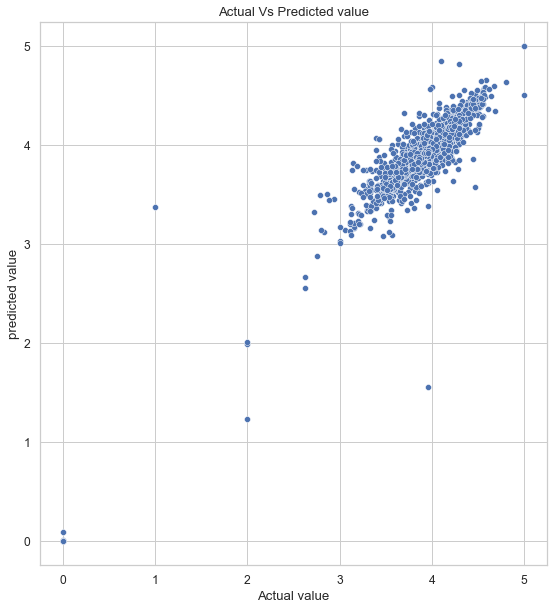

In [73]:
# Check for Linearity

f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test,y=y_pred,ax=ax)
plt.xlabel('Actual value')
plt.ylabel('predicted value')
ax.set_title('Actual Vs Predicted value')

# => Apart from about 5 outliers. The predictions are enough goods and the model generalises well the data on the test set.